In [ ]:
!pip install pyarrow datasets huggingface_hub
!pip install nlpaug
!pip install pyspellchecker

# Importing Packages

In [ ]:
from google.colab import drive
import os
import json
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
from datetime import datetime
from tqdm import tqdm
from spellchecker import SpellChecker
from textblob import TextBlob
import nlpaug.augmenter.word as naw

from datasets import load_dataset, load_from_disk, DownloadMode, DatasetDict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from transformers import AutoTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, BatchNormalization, Bidirectional, GRU, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2


# Mounting Google Drive (Only for Colab)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)

# Define the destination folder
destination_path = "/content/drive/MyDrive/Anvendt Maskinlæring - Eksamen/Data/Data_problem_2"



Mounted at /content/drive


# Loading the Dataset

In [ ]:
dataset_emotion = load_dataset(
    "dair-ai/emotion", "unsplit",
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
)

# Initial Split of the Dataset

In [ ]:
# Split the emotion dataset into training, and test sets
hf_train = dataset_emotion['train'].train_test_split(test_size=0.1, shuffle=True, seed=42)
hf_test  = hf_train['test']
hf_train = hf_train['train']

# Split the training set into training and validation sets
hf_train = hf_train.train_test_split(test_size=0.2, shuffle=True, seed=42)
# Rename just to make it easier to understand
hf_train = DatasetDict({
    'validation': hf_train['test'],
    'train': hf_train['train']
})
hf_validation = hf_train['validation']
hf_train = hf_train['train']

# Display the sizes of the splits
print(f"Train dataset size: {len(hf_train)}")
print(f"Validation dataset size: {len(hf_validation)}")
print(f"Test dataset size: {len(hf_test)}")

Train dataset size: 300102
Validation dataset size: 75026
Test dataset size: 41681


# Counting Number of Classes in Train, Validation, and Test Set

In [ ]:
# Count label distributions for train, validation, and test datasets
train_labels = [example['label'] for example in hf_train]
val_labels = [example['label'] for example in hf_validation]
test_labels = [example['label'] for example in hf_test]

# Get label distributions
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

# Create a DataFrame for easier visualization
label_distribution = pd.DataFrame({
    "Train": train_label_counts,
    "Validation": val_label_counts,
    "Test": test_label_counts
}).fillna(0).astype(int)

# Display the distribution
print(label_distribution)



    Train  Validation   Test
2   24908        6161   3485
0   87347       21778  12062
1  101391       25549  14127
5   10719        2697   1556
4   34359        8582   4771
3   41378       10259   5680


# Visualizing the Distributions of Classes in Train, Validation, and Test Set

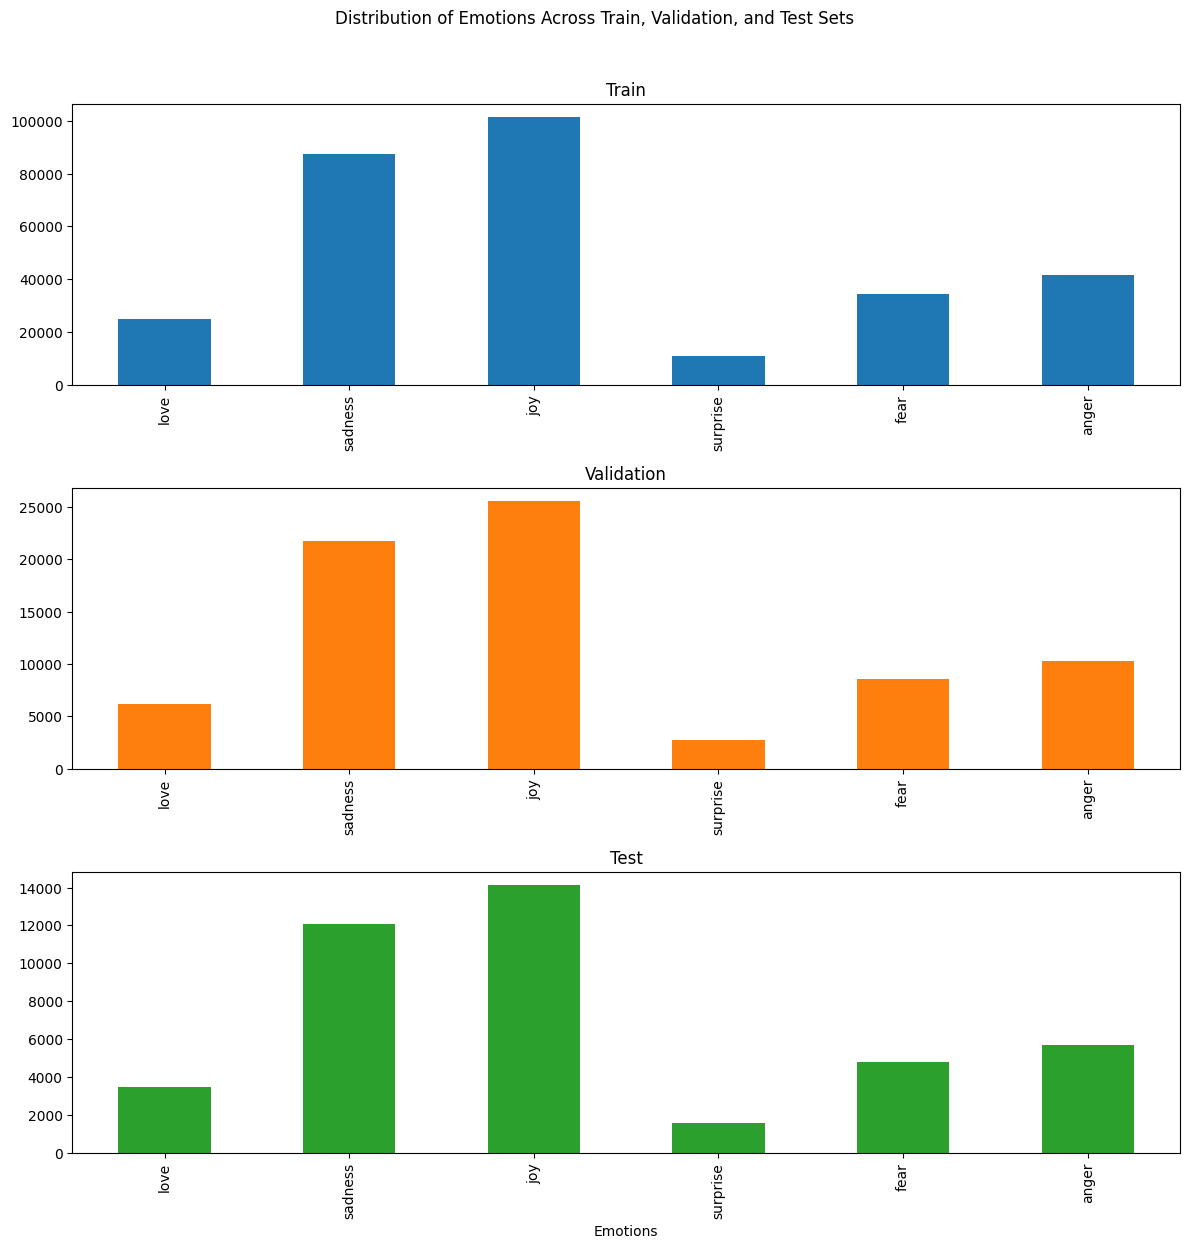

In [ ]:
# Define the mapping of label numbers to emotion names
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Update the index of the label_distribution DataFrame with emotion names
label_distribution_named = label_distribution.rename(index=label_mapping)

# Plot separate bar plots for train, validation, and test in the same figure
label_distribution_named.plot(
    kind="bar",
    figsize=(12, 12),
    subplots=True,
    layout=(3, 1),
    sharex=False,
    legend=False
)

# Add titles for each subplot
plt.suptitle("Distribution of Emotions Across Train, Validation, and Test Sets", y=1.02)
plt.tight_layout()
plt.xlabel("Emotions")
plt.show()


# Visualizing Tweet Lengths

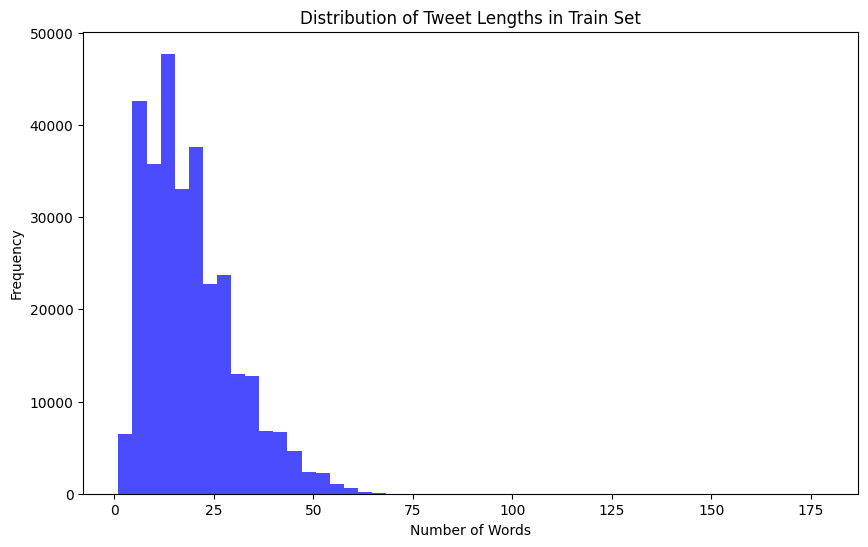

In [ ]:
# Measure tweet lengths
tweet_lengths_train = [len(text.split()) for text in hf_train['text']]  # Word count per tweet

# Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths_train, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

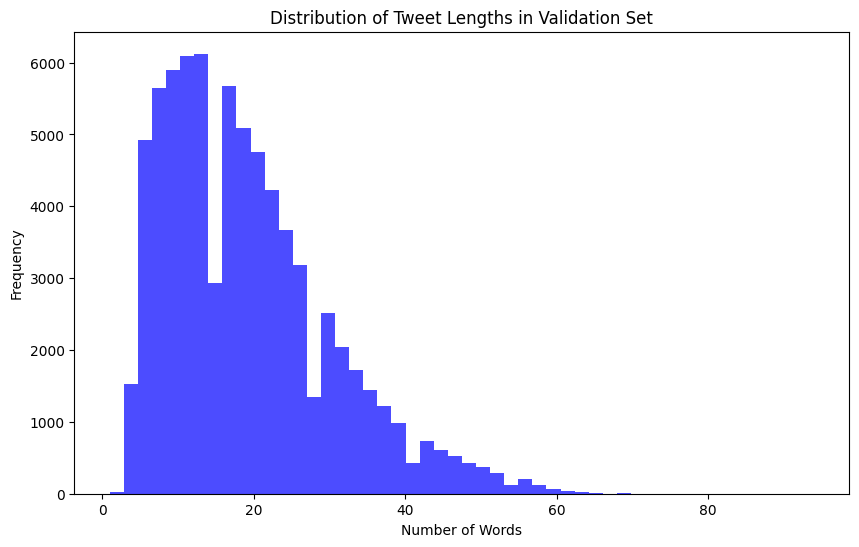

In [ ]:
# Measure tweet lengths
tweet_lengths_validation = [len(text.split()) for text in hf_validation['text']]  # Word count per tweet

# Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths_validation, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Validation Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

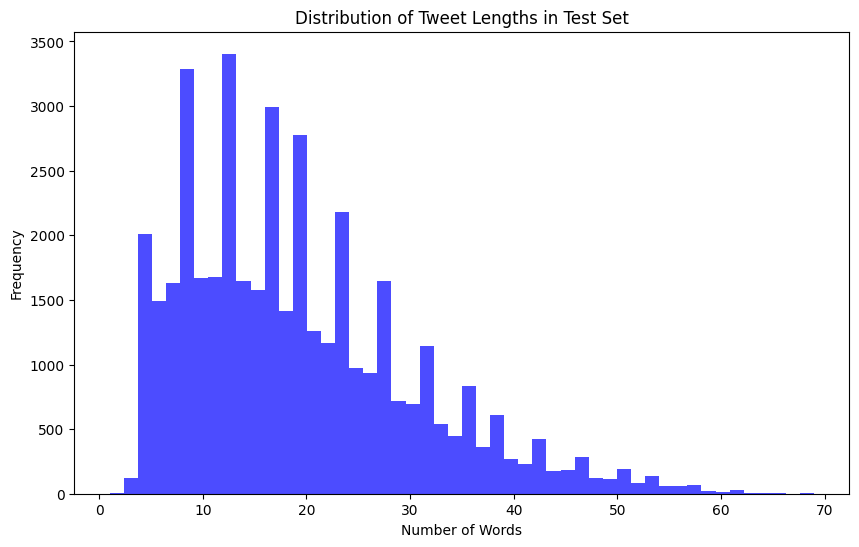

In [ ]:
# Measure tweet lengths
tweet_lengths_test = [len(text.split()) for text in hf_test['text']]  # Word count per tweet

# Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths_test, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Test Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Concatenating the Train, Validation and Test Set into one Dataset

In [ ]:
from datasets import concatenate_datasets

# Combine the datasets using concatenate_datasets
combined_dataset = concatenate_datasets([hf_train, hf_validation, hf_test])

print(len(combined_dataset))


416809


# Resplitting the Dataset, ensuring equal Distribution of Tweet Lengths

In [ ]:
from sklearn.model_selection import train_test_split

import numpy as np

# Compute tweet lengths for all texts in combined_dataset
tweet_lengths = [len(text.split()) for text in combined_dataset['text']]

# Bin tweet lengths into categories (e.g., short, medium, long)
tweet_length_bins = np.digitize(tweet_lengths, bins=[10, 20, 50])  # Define bin edges
# Bins: 0 = <=10 words, 1 = 11-20 words, 2 = 21-50 words, 3 = >50 words

# Perform stratified split using the bins
train_indices, temp_indices = train_test_split(
    range(len(combined_dataset)),
    test_size=0.25,
    stratify=tweet_length_bins,
    random_state=42
)

# Further split temp_indices into validation and test sets
val_bins = [tweet_length_bins[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.30,
    stratify=val_bins,
    random_state=42
)

# Create new DatasetDict
recombined_dataset = DatasetDict({
    'train': combined_dataset.select(train_indices),
    'validation': combined_dataset.select(val_indices),
    'test': combined_dataset.select(test_indices)
})

# Checking Number of Observations in new Train, Validation and Test set

In [ ]:
# Assign splits to convenient variables
hf_train = recombined_dataset['train']
hf_validation = recombined_dataset['validation']
hf_test = recombined_dataset['test']

# Verify sizes of the splits
print(f"Train dataset size: {len(hf_train)}")
print(f"Validation dataset size: {len(hf_validation)}")
print(f"Test dataset size: {len(hf_test)}")

Train dataset size: 312606
Validation dataset size: 72942
Test dataset size: 31261


# Visualizing the New Tweets Lengths for the Train, Validation, and Test Set

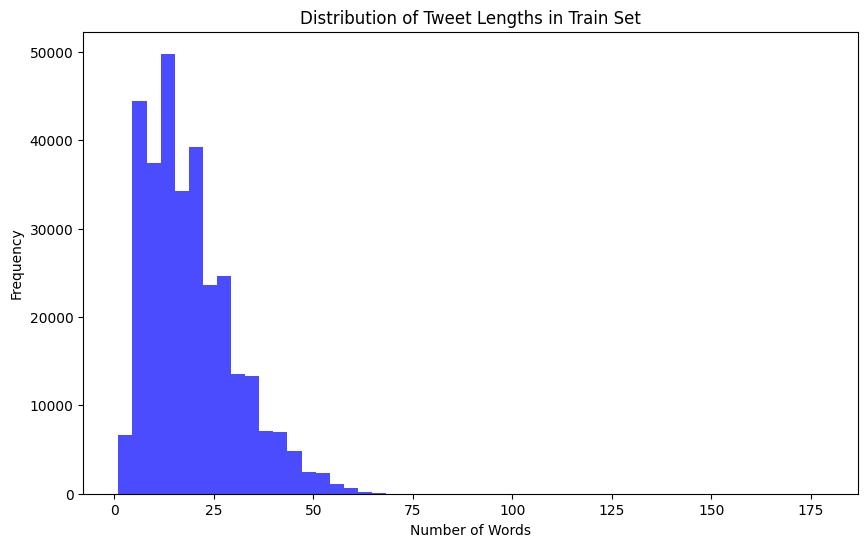

In [ ]:
# Step 1: Measure tweet lengths
tweet_lengths = [len(text.split()) for text in hf_train['text']]  # Word count per tweet

# Step 2: Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

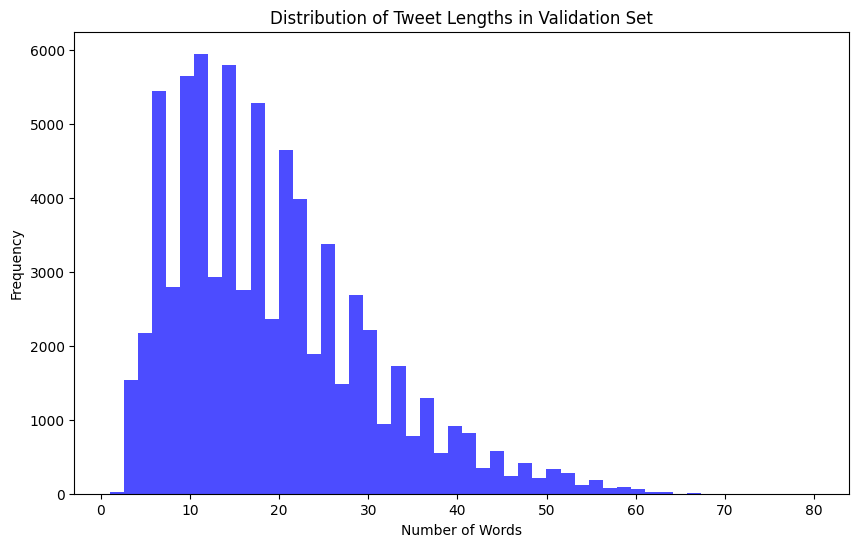

In [ ]:
# Step 1: Measure tweet lengths
tweet_lengths = [len(text.split()) for text in hf_validation['text']]  # Word count per tweet

# Step 2: Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Validation Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

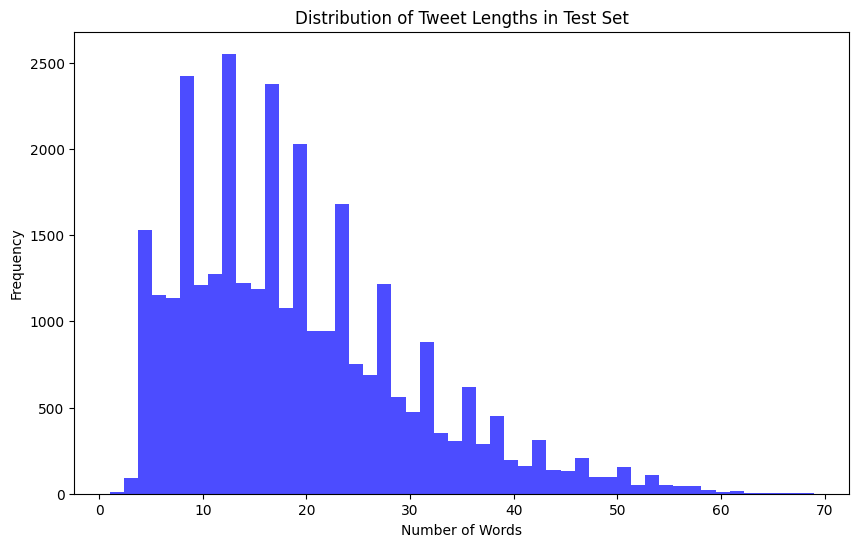

In [ ]:
# Step 1: Measure tweet lengths
tweet_lengths = [len(text.split()) for text in hf_test['text']]  # Word count per tweet

# Step 2: Analyze distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Tweet Lengths in Test Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Checking for Duplicates

In [ ]:
# Combine all datasets into one list
all_texts = hf_train['text'] + hf_validation['text'] + hf_test['text']

# Count occurrences across all datasets
all_text_counts = Counter(all_texts)

# Filter tweets that appear more than once
duplicate_tweets = [tweet for tweet, count in all_text_counts.items() if count > 1]


# Print the first 5 duplicated tweets
for i, tweet in enumerate(duplicate_tweets[:5]):
    print(f"Duplicate Tweet {i+1}: {tweet}")

Duplicate Tweet 1: i feel that the last gracious help i can do for him is to let go
Duplicate Tweet 2: i feel like i wont be accepted
Duplicate Tweet 3: i feel like caving though all i have to do is to imagine my hands hurting so much i can t dig in the garden stroke my beloved s face or write the truth
Duplicate Tweet 4: i feel weird when im in the lift with the suit
Duplicate Tweet 5: i confessed all this to her in the belief that my outpouring of honesty and feelings would be accepted


# Print the Number of Duplicated Tweets

In [ ]:
print(len(duplicate_tweets))

22817


# Checking the Labels of the Duplicated Tweets

In [ ]:
# Count occurrences of each tweet
tweet_counts_train = Counter(hf_train['text'])
tweet_counts_validation = Counter(hf_validation['text'])
tweet_counts_test = Counter(hf_test['text'])

# Combine counts from all datasets
tweet_counts = tweet_counts_train + tweet_counts_validation + tweet_counts_test

# Filter tweets that appear more than once
duplicates = [tweet for tweet, count in tweet_counts.items() if count > 1]

print(f'Number of duplicates: {len(duplicates)}')

# Step 3: Display the labels assigned to the duplicated tweets
print("Labels for duplicated tweets:")
for i, tweet in enumerate(duplicates[:5], 1):  # Display the first 5 tweets
    # Find all indices where this tweet occurs
    indices = [idx for idx, text in enumerate(hf_train['text']) if text == tweet]
    # Get the associated labels for this tweet
    labels = [hf_train['label'][idx] for idx in indices]
    print(f"{i}: Tweet: '{tweet}'")
    print(f"   Assigned Labels: {[label_mapping[label] for label in labels]}")

Number of duplicates: 22817
Labels for duplicated tweets:
1: Tweet: 'i feel that the last gracious help i can do for him is to let go'
   Assigned Labels: ['love', 'joy']
2: Tweet: 'i feel like i wont be accepted'
   Assigned Labels: ['love', 'joy']
3: Tweet: 'i feel like caving though all i have to do is to imagine my hands hurting so much i can t dig in the garden stroke my beloved s face or write the truth'
   Assigned Labels: ['joy', 'love']
4: Tweet: 'i feel weird when im in the lift with the suit'
   Assigned Labels: ['fear', 'surprise']
5: Tweet: 'i confessed all this to her in the belief that my outpouring of honesty and feelings would be accepted'
   Assigned Labels: ['love', 'joy']


# Resolving Duplicate Tweets by Assigning the Observations the Most Frequent Label

In [ ]:
from datasets import Dataset

# Step 1: Calculate global label frequencies
all_labels = hf_train['label'] + hf_validation['label'] + hf_test['label']
global_label_counts = Counter(all_labels)
print("Global label frequencies (across all datasets):")
print({label_mapping[label]: count for label, count in global_label_counts.items()})

# Define specific tweets for verification
specific_tweets = [
    'i grabbed something to eat before the evening class feeling strange in the food court with my very high heels surrounded by students in much more comfortable footwear',
    'i need to think of it differently this way i wont have blood gushing out of my nose and not feel overwhelmed at times where i feel as if i am being smothered',
    'i cannot even explain it to myself so i just laugh and smile and feel amazing',
    'i feel agitated i become easily overwhelmed',
    'i just feel so stressed out with life'
]

def resolve_duplicates(texts, labels, dataset_name):
    """
    Resolve duplicates in a dataset by assigning the most frequent global label.
    """
    # Step 2: Group tweets by their associated labels
    tweet_labels = defaultdict(list)
    for text, label in zip(texts, labels):
        tweet_labels[text].append(label)

    # Step 3: Resolve duplicates by assigning the most frequent global label
    resolved_texts = []
    resolved_labels = []

    for tweet, tweet_labels_list in tweet_labels.items():
        # Count occurrences of each label for this tweet
        label_counts = Counter(tweet_labels_list)
        # Assign the most globally frequent label
        most_frequent_label = max(label_counts, key=lambda label: global_label_counts[label])
        resolved_texts.append(tweet)
        resolved_labels.append(most_frequent_label)

        # Print specific tweets for verification
        if tweet in specific_tweets:
            print(f"Tweet: '{tweet}'")
            print(f"   Original Labels: {[label_mapping[label] for label in tweet_labels_list]}")
            print(f"   Assigned Label: {label_mapping[most_frequent_label]}")

    # Step 4: Display results
    num_duplicates_resolved = len(tweet_labels) - len(set(texts))

    return resolved_texts, resolved_labels

# Resolve duplicates for training, validation, and test datasets
resolved_train_texts, resolved_train_labels = resolve_duplicates(hf_train['text'], hf_train['label'], "training")
resolved_val_texts, resolved_val_labels = resolve_duplicates(hf_validation['text'], hf_validation['label'], "validation")
resolved_test_texts, resolved_test_labels = resolve_duplicates(hf_test['text'], hf_test['label'], "test")

# Create new datasets with resolved duplicates
hf_train = Dataset.from_dict({'text': resolved_train_texts, 'label': resolved_train_labels})
hf_validation = Dataset.from_dict({'text': resolved_val_texts, 'label': resolved_val_labels})
hf_test = Dataset.from_dict({'text': resolved_test_texts, 'label': resolved_test_labels})

print("Duplicates resolved in all datasets based on global label frequencies.")


Global label frequencies (across all datasets):
{'anger': 57317, 'sadness': 121187, 'fear': 47712, 'love': 34554, 'joy': 141067, 'surprise': 14972}
Tweet: 'i feel agitated i become easily overwhelmed'
   Original Labels: ['anger', 'fear']
   Assigned Label: anger
Tweet: 'i just feel so stressed out with life'
   Original Labels: ['sadness', 'anger']
   Assigned Label: sadness
Tweet: 'i need to think of it differently this way i wont have blood gushing out of my nose and not feel overwhelmed at times where i feel as if i am being smothered'
   Original Labels: ['surprise', 'fear']
   Assigned Label: fear
Tweet: 'i grabbed something to eat before the evening class feeling strange in the food court with my very high heels surrounded by students in much more comfortable footwear'
   Original Labels: ['surprise']
   Assigned Label: surprise
Tweet: 'i cannot even explain it to myself so i just laugh and smile and feel amazing'
   Original Labels: ['joy', 'surprise']
   Assigned Label: joy
Tw

# Count Remaining Duplicates

In [ ]:
# Count occurrences of each tweet
tweet_counts_train = Counter(hf_train['text'])
tweet_counts_validation = Counter(hf_validation['text'])
tweet_counts_test = Counter(hf_test['text'])

# Combine counts from all datasets
tweet_counts = tweet_counts_train + tweet_counts_validation + tweet_counts_test

# Filter tweets that appear more than once
duplicates = [tweet for tweet, count in tweet_counts.items() if count > 1]

print(f'Number of duplicates: {len(duplicates)}')

Number of duplicates: 9119


# Ensure no Overlaps

In [ ]:
# Step 2: Check for overlaps between datasets
train_texts = set(hf_train['text'])
val_texts = set(hf_validation['text'])
test_texts = set(hf_test['text'])

# Identify overlaps
overlap_train_val = train_texts & val_texts
overlap_train_test = train_texts & test_texts
overlap_val_test = val_texts & test_texts

# Display overlaps
print(f"Overlaps between Train and Validation: {len(overlap_train_val)}")
print(f"Overlaps between Train and Test: {len(overlap_train_test)}")
print(f"Overlaps between Validation and Test: {len(overlap_val_test)}")

# Remove overlaps
hf_validation = {
    'text': [text for text in hf_validation['text'] if text not in train_texts and text not in overlap_val_test],
    'label': [label for text, label in zip(hf_validation['text'], hf_validation['label']) if text not in train_texts and text not in overlap_val_test]
}

hf_test = {
    'text': [text for text in hf_test['text'] if text not in train_texts and text not in val_texts],
    'label': [label for text, label in zip(hf_test['text'], hf_test['label']) if text not in train_texts and text not in val_texts]
}

# Convert updated validation and test sets back to Dataset objects
hf_validation = Dataset.from_dict(hf_validation)
hf_test = Dataset.from_dict(hf_test)

# Recalculate and print remaining overlaps
val_texts = set(hf_validation['text'])
test_texts = set(hf_test['text'])

print(f"Remaining overlaps between Train and Validation: {len(train_texts & val_texts)}")
print(f"Remaining overlaps between Train and Test: {len(train_texts & test_texts)}")
print(f"Remaining overlaps between Validation and Test: {len(val_texts & test_texts)}")


Overlaps between Train and Validation: 5966
Overlaps between Train and Test: 2574
Overlaps between Validation and Test: 595
Remaining overlaps between Train and Validation: 0
Remaining overlaps between Train and Test: 0
Remaining overlaps between Validation and Test: 0


# Sanity Check by ensuring no Duplicates are left

In [ ]:
# Count occurrences of each tweet
tweet_counts_train = Counter(hf_train['text'])
tweet_counts_validation = Counter(hf_validation['text'])
tweet_counts_test = Counter(hf_test['text'])

# Combine counts from all datasets
tweet_counts = tweet_counts_train + tweet_counts_validation + tweet_counts_test

# Filter tweets that appear more than once
duplicates = [tweet for tweet, count in tweet_counts.items() if count > 1]

print(f'Number of duplicates: {len(duplicates)}')

Number of duplicates: 0


# Building a Vocabulary/Tokenization and Padding

In [ ]:
tokenized_texts = [text.split() for text in train_texts]
unique_tokens = set(word for tweet in tokenized_texts for word in tweet)
print(len(unique_tokens), "unique tokens in training set.")


65796 unique tokens in training set.


# Checking Number of Unique Tokens (words), Number of Total Tokens, and how many Tokens are needed to cover 95% of the Word Occurences

In [ ]:
train_texts = hf_train['text']

# 1. Tokenize everything in your training set
tokenized_texts = [text.split() for text in train_texts]

# 2. Flatten the list of lists to get a single list of all tokens
all_tokens = [token for tokens in tokenized_texts for token in tokens]

# 3. Count frequencies
freq_counter = Counter(all_tokens)
print(f"Number of unique tokens: {len(freq_counter)}")

# 4. Sort words by descending frequency
sorted_token_freqs = freq_counter.most_common()  # list of (word, count), sorted descending
total_tokens = sum(freq_counter.values())        # total occurrences of all tokens

print(f"Total token occurrences in train set: {total_tokens}")

# 5. Compute cumulative coverage
cumulative = 0
coverage_break = 0.95  # or 0.90, 0.98, etc.
needed_words = 0

for i, (token, count) in enumerate(sorted_token_freqs, start=1):
    cumulative += count
    if (cumulative / total_tokens) >= coverage_break:
        needed_words = i
        break

print(f"To cover {coverage_break*100}% of word occurrences, you need ~{needed_words} words.")



Number of unique tokens: 65796
Total token occurrences in train set: 5751770
To cover 95.0% of word occurrences, you need ~4641 words.


# Defining the Train, Validation, and Test Texts (Tweets) and the Train, Validationa and Test Labels (Classes)

In [ ]:
train_texts = hf_train['text']
val_texts   = hf_validation['text']
test_texts  = hf_test['text']

y_train = hf_train['label']
y_val   = hf_validation['label']
y_test  = hf_test['label']

print(len(train_texts))
print(len(val_texts))
print(len(test_texts))

299527
65739
27969


# Creating the Vocabulary

In [ ]:


MAX_VOCAB_SIZE = 6000

encoder = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode='int'
)

encoder.adapt(train_texts)  # Build vocabulary from training texts


# 2. Inspect the Vocabulary

vocab = np.array(encoder.get_vocabulary())
print(f"First 50 words in the vocabulary:\n{vocab[:50]}\n")
print(f"Vocabulary length: {len(vocab)}")

First 50 words in the vocabulary:
['' '[UNK]' 'i' 'feel' 'and' 'to' 'the' 'a' 'feeling' 'that' 'of' 'my'
 'in' 'it' 'like' 'so' 'for' 'im' 'have' 'me' 'but' 'was' 'is' 'am' 'this'
 'with' 'not' 'be' 'about' 'as' 'on' 'you' 'just' 'at' 'when' 'or' 'all'
 'because' 'more' 'do' 'really' 'can' 'up' 't' 'know' 'very' 'by' 'are'
 'been' 'out']

Vocabulary length: 6000


In [ ]:
# Encode each split separately
encoded_train = encoder(train_texts).numpy()
encoded_val   = encoder(val_texts).numpy()
encoded_test  = encoder(test_texts).numpy()

print("Example of encoded train data:", encoded_train[0])
print("Shape of encoded train:", encoded_train.shape)


Example of encoded train data: [  2 286 114 138   2  18  48   8 106 692   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Shape of encoded train: (299527, 178)


# Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 50

X_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')
X_val   = pad_sequences(encoded_val, maxlen=max_length, padding='post', truncating='post')
X_test  = pad_sequences(encoded_test, maxlen=max_length, padding='post', truncating='post')

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print(hf_train[0])
print("Example of encoded train data:", X_train[0])


X_train shape: (299527, 50)
X_val shape: (65739, 50)
X_test shape: (27969, 50)
{'text': 'i must say though i have been feeling pretty violent', 'label': 3}
Example of encoded train data: [  2 286 114 138   2  18  48   8 106 692   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Standard RNN

In [ ]:
from tensorflow.keras import layers, Sequential

In [ ]:


Standard_RNN_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),

    layers.SimpleRNN(128, dropout=0.2),

    layers.Dense(6, activation='softmax')
])

Standard_RNN_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Standard_RNN_model.build(input_shape=(None, max_length))

Standard_RNN_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801,670 (3.06 MB)

 Trainable params: 801,670 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

# Standard GRU

In [ ]:
Standard_GRU_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),

    layers.GRU(128, dropout=0.2),

    layers.Dense(6, activation='softmax')
])

Standard_GRU_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Standard_GRU_model.build(input_shape=(None, max_length))

Standard_GRU_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 867,846 (3.31 MB)

 Trainable params: 867,846 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

# Standard LSTM

In [ ]:
Standard_LSTM_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),

    layers.LSTM(128, dropout=0.2),

    layers.Dense(6, activation='softmax')
])

Standard_LSTM_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Standard_LSTM_model.build(input_shape=(None, max_length))

Standard_LSTM_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 900,358 (3.43 MB)

 Trainable params: 900,358 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

# Bidirectional RNN

In [ ]:
Bidirectional_RNN_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),

    layers.Bidirectional(layers.SimpleRNN(128,
                                          dropout=0.2),
    ),

    layers.Dense(6, activation='softmax')
])

Bidirectional_RNN_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Bidirectional_RNN_model.build(input_shape=(None, max_length))

Bidirectional_RNN_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835,334 (3.19 MB)

 Trainable params: 835,334 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

# Bidirectioanl GRU

In [ ]:
Bidirectional_GRU_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),
    layers.Bidirectional(
        layers.GRU(128,
                   dropout=0.2)
    ),
    layers.Dense(6,
                 activation='softmax')  # 6 emotion classes
])

Bidirectional_GRU_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # if labels are int-coded
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Bidirectional_GRU_model.build(input_shape=(None, max_length))

Bidirectional_GRU_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 967,686 (3.69 MB)

 Trainable params: 967,686 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

# Bidirectioanl LSTM

In [ ]:
Bidirectional_LSTM_model = Sequential([
    layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,  # must match or exceed your vocabulary size
        output_dim=128,            # embedding vector size
        input_length=max_length,   # the same length you used in pad_sequences
        mask_zero=True             # optional: treat 0 as padding
    ),

    layers.Bidirectional(layers.LSTM(128,
                                          dropout=0.2),
    ),

    layers.Dense(6, activation='softmax')
])

Bidirectional_LSTM_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with input shape
Bidirectional_LSTM_model.build(input_shape=(None, max_length))

Bidirectional_LSTM_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 50, 128)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,032,710 (3.94 MB)

 Trainable params: 1,032,710 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# Class Weights

In [ ]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights = dict(enumerate(class_weights_array))
print(weights)


{0: 0.5505747887049516, 1: 0.4728681803399292, 2: 2.4701220517895432, 3: 1.205563202846402, 4: 1.4986840788551987, 5: 5.974289931386628}


# Fitting the models

In [ ]:
X_train = X_train.astype('int32')
X_val   = X_val.astype('int32')
X_test  = X_test.astype('int32')

print(X_train.dtype)  # int32
print(X_train.shape)  # (num_samples, 50)


int32
(299527, 50)


In [ ]:
y_train = np.array(y_train, dtype='int32')
y_val = np.array(y_val, dtype='int32')
y_test = np.array(y_test, dtype='int32')

print(y_train.dtype)  # int32
print(y_train.shape)  # (num_samples,)


int32
(299527,)


In [ ]:
# Standard RNN
history = Standard_RNN_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.6946 - loss: 0.8498 - val_accuracy: 0.9416 - val_loss: 0.2322
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8997 - loss: 0.3291 - val_accuracy: 0.9368 - val_loss: 0.2778
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9055 - loss: 0.3230 - val_accuracy: 0.9450 - val_loss: 0.2348
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9146 - loss: 0.2776 - val_accuracy: 0.9410 - val_loss: 0.2437
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9151 - loss: 0.2745 - val_accuracy: 0.9300 - val_loss: 0.2733
Epoch 6/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9123 - loss: 0.2490 - val_accuracy: 0.9272 - val_loss: 0.2784


In [ ]:
# Bidirectional RNN
history = Bidirectional_RNN_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.7016 - loss: 0.7884 - val_accuracy: 0.7978 - val_loss: 0.8088
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.9069 - loss: 0.2545 - val_accuracy: 0.9511 - val_loss: 0.1754
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9087 - loss: 0.2554 - val_accuracy: 0.9516 - val_loss: 0.1607
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9250 - loss: 0.2009 - val_accuracy: 0.9571 - val_loss: 0.1352
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9355 - loss: 0.1612 - val_accuracy: 0.9557 - val_loss: 0.1557
Epoch 6/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.9306 - loss: 0.1844 - val_accuracy: 0.9556 - val_loss: 0.1623
Epoch 7/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.9275 - loss: 0.2092 - val_accuracy: 0.9378 - val_loss: 0.2308
Epoch 8/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9317 -

In [ ]:
# Standard GRU
history = Standard_GRU_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8084 - loss: 0.4904 - val_accuracy: 0.9873 - val_loss: 0.0335
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9583 - loss: 0.0796 - val_accuracy: 0.9863 - val_loss: 0.0308
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9635 - loss: 0.0702 - val_accuracy: 0.9877 - val_loss: 0.0296
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9690 - loss: 0.0624 - val_accuracy: 0.9871 - val_loss: 0.0322
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9718 - loss: 0.0562 - val_accuracy: 0.9890 - val_loss: 0.0291
Epoch 6/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9757 - loss: 0.0482 - val_accuracy: 0.9866 - val_loss: 0.0357
Epoch 7/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9795 - loss: 0.0420 - val_accuracy: 0.9881 - val_loss: 0.0333
Epoch 8/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9827 - loss: 0

In [ ]:
# Bidirectional GRU
history = Bidirectional_GRU_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7987 - loss: 0.4777 - val_accuracy: 0.9856 - val_loss: 0.0340
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9595 - loss: 0.0775 - val_accuracy: 0.9854 - val_loss: 0.0362
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9651 - loss: 0.0702 - val_accuracy: 0.9887 - val_loss: 0.0287
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9705 - loss: 0.0598 - val_accuracy: 0.9877 - val_loss: 0.0296
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9761 - loss: 0.0495 - val_accuracy: 0.9877 - val_loss: 0.0326
Epoch 6/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9810 - loss: 0.0414 - val_accuracy: 0.9896 - val_loss: 0.0298
Epoch 7/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9847 - loss: 0.0339 - val_accuracy: 0.9891 - val_loss: 0.0331
Epoch 8/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9874 - loss: 0

In [ ]:
# Standard LSTM
history = Standard_LSTM_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8161 - loss: 0.5352 - val_accuracy: 0.9836 - val_loss: 0.0438
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9555 - loss: 0.0868 - val_accuracy: 0.9865 - val_loss: 0.0314
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9621 - loss: 0.0736 - val_accuracy: 0.9864 - val_loss: 0.0310
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9665 - loss: 0.0664 - val_accuracy: 0.9862 - val_loss: 0.0320
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9716 - loss: 0.0592 - val_accuracy: 0.9883 - val_loss: 0.0295


In [ ]:
# Bidirectional LSTM
history = Bidirectional_LSTM_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.8182 - loss: 0.5084 - val_accuracy: 0.9825 - val_loss: 0.0512
Epoch 2/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9581 - loss: 0.0841 - val_accuracy: 0.9833 - val_loss: 0.0383
Epoch 3/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9617 - loss: 0.0725 - val_accuracy: 0.9852 - val_loss: 0.0367
Epoch 4/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9667 - loss: 0.0646 - val_accuracy: 0.9854 - val_loss: 0.0357
Epoch 5/30
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9712 - loss: 0.0563 - val_accuracy: 0.9869 - val_loss: 0.0330


# Test Scores

In [ ]:
from sklearn.metrics import accuracy_score

# Standard RNN
rnn_predictions = Standard_RNN_model.predict(X_test)
rnn_predicted_labels = rnn_predictions.argmax(axis=1)
standard_rnn_accuracy = accuracy_score(y_test, rnn_predicted_labels)

# Bidirectional RNN
bidir_rnn_predictions = Bidirectional_RNN_model.predict(X_test)
bidir_rnn_predicted_labels = bidir_rnn_predictions.argmax(axis=1)
bidirectional_rnn_accuracy = accuracy_score(y_test, bidir_rnn_predicted_labels)

# Standard GRU
gru_predictions = Standard_GRU_model.predict(X_test)
gru_predicted_labels = gru_predictions.argmax(axis=1)
standard_gru_accuracy = accuracy_score(y_test, gru_predicted_labels)

# Bidirectional GRU
bidir_gru_predictions = Bidirectional_GRU_model.predict(X_test)
bidir_gru_predicted_labels = bidir_gru_predictions.argmax(axis=1)
bidirectional_gru_accuracy = accuracy_score(y_test, bidir_gru_predicted_labels)

# Standard LSTM
lstm_predictions = Standard_LSTM_model.predict(X_test)
lstm_predicted_labels = lstm_predictions.argmax(axis=1)
standard_lstm_accuracy = accuracy_score(y_test, lstm_predicted_labels)

# Bidirectional LSTM
bidir_lstm_predictions = Bidirectional_LSTM_model.predict(X_test)
bidir_lstm_predicted_labels = bidir_lstm_predictions.argmax(axis=1)
bidirectional_lstm_accuracy = accuracy_score(y_test, bidir_lstm_predicted_labels)


print(f"Standard RNN Test Accuracy: {standard_rnn_accuracy:.4f}")
print(f"Bidirectional RNN Test Accuracy: {bidirectional_rnn_accuracy:.4f}")
print(f"Standard GRU Test Accuracy: {standard_gru_accuracy:.4f}")
print(f"Bidirectional GRU Test Accuracy: {bidirectional_gru_accuracy:.4f}")
print(f"Standard LSTM Test Accuracy: {standard_lstm_accuracy:.4f}")
print(f"Bidirectional LSTM Test Accuracy: {bidirectional_lstm_accuracy:.4f}")


875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Standard RNN Test Accuracy: 0.9427
Bidirectional RNN Test Accuracy: 0.9691
Standard GRU Test Accuracy: 0.9912
Bidirectional GRU Test Accuracy: 0.9908
Standard LSTM Test Accuracy: 0.9850
Bidirectional LSTM Test Accuracy: 0.9852


# Classification Reports on the Test Score

In [ ]:
from sklearn.metrics import classification_report

# Standard RNN
test_predictions_rnn = Standard_RNN_model.predict(X_test)
test_predicted_labels_rnn = test_predictions_rnn.argmax(axis=1)
test_classification_report_rnn = classification_report(y_test, test_predicted_labels_rnn, target_names=label_mapping.values())

# Bidirectional RNN
test_predictions_bidir_rnn = Bidirectional_RNN_model.predict(X_test)
test_predicted_labels_bidir_rnn = test_predictions_bidir_rnn.argmax(axis=1)
test_classification_report_bidir_rnn = classification_report(y_test, test_predicted_labels_bidir_rnn, target_names=label_mapping.values())

# Standard GRU
test_predictions_gru = Standard_GRU_model.predict(X_test)
test_predicted_labels_gru = test_predictions_gru.argmax(axis=1)
test_classification_report_gru = classification_report(y_test, test_predicted_labels_gru, target_names=label_mapping.values())

# Bidirectional GRU
test_predictions_bidir_gru = Bidirectional_GRU_model.predict(X_test)
test_predicted_labels_bidir_gru = test_predictions_bidir_gru.argmax(axis=1)
test_classification_report_bidir_gru = classification_report(y_test, test_predicted_labels_bidir_gru, target_names=label_mapping.values())

# Standard LSTM
test_predictions_lstm = Standard_LSTM_model.predict(X_test)
test_predicted_labels_lstm = test_predictions_lstm.argmax(axis=1)
test_classification_report_lstm = classification_report(y_test, test_predicted_labels_lstm, target_names=label_mapping.values())

# Bidirectional LSTM
test_predictions_bidir_lstm = Bidirectional_LSTM_model.predict(X_test)
test_predicted_labels_bidir_lstm = test_predictions_bidir_lstm.argmax(axis=1)
test_classification_report_bidir_lstm = classification_report(y_test, test_predicted_labels_bidir_lstm, target_names=label_mapping.values())

print("Classification Report for Standard RNN:")
print(test_classification_report_rnn)

print("Classification Report for Bidirectional RNN:")
print(test_classification_report_bidir_rnn)

print("Classification Report for Standard GRU:")
print(test_classification_report_gru)

print("Classification Report for Bidirectional GRU:")
print(test_classification_report_bidir_gru)

print("Classification Report for Standard LSTM:")
print(test_classification_report_lstm)

print("Classification Report for Bidirectional LSTM:")
print(test_classification_report_bidir_lstm)


875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Classification Report for Standard RNN:
              precision    recall  f1-score   support

     sadness       0.97      0.94      0.95      8821
         joy       0.98      0.92      0.95      9714
        love       0.86      0.98      0.91      1839
       anger       0.90      0.97      0.93      3897
        fear       0.90      0.96      0.93      3001
    surprise       0.80      0.98      0.88       697

    accuracy                           0.94     27969
   macro avg       0.90      0.96      0.93     27969
weighted avg       0.95      0.94      0.94     27969

Classification Report for Bidirectional RNN:
              precision    recall  f1-score   support

     sadness       0.99      0.97      0.98      8821
         joy     

# Confusion Matrices

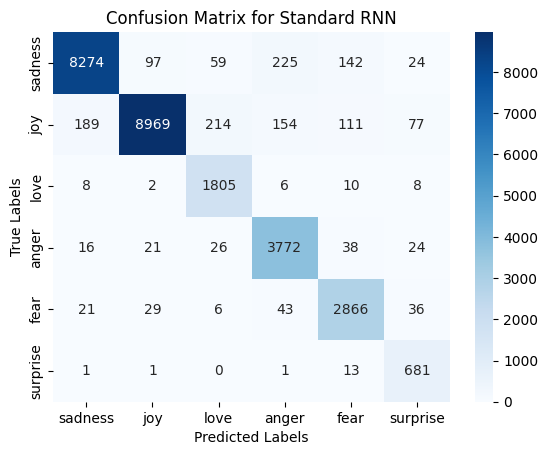

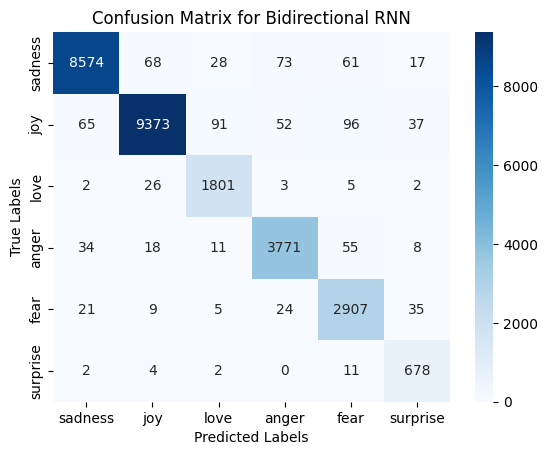

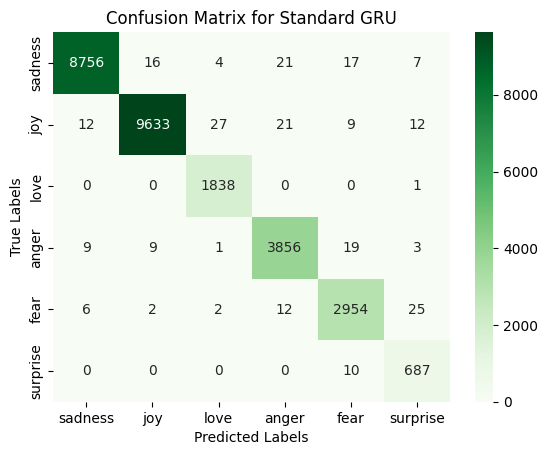

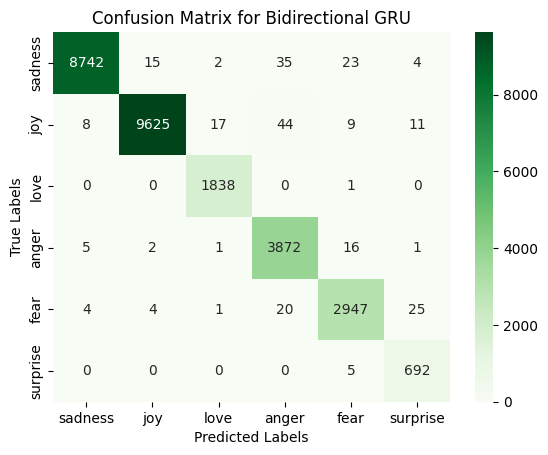

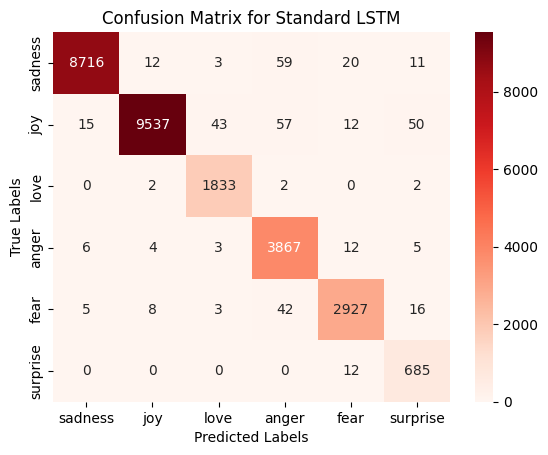

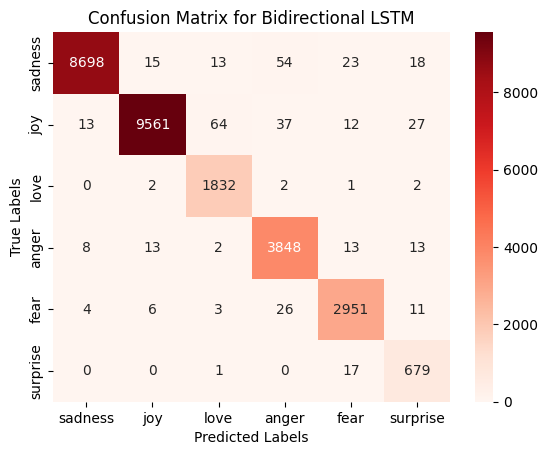

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

heatmap_colors = {
    "Standard RNN": "Blues",
    "Bidirectional RNN": "Blues",
    "Standard GRU": "Greens",
    "Bidirectional GRU": "Greens",
    "Standard LSTM": "Reds",
    "Bidirectional LSTM": "Reds"
}


# Standard RNN
cm_rnn = confusion_matrix(y_test, test_predicted_labels_rnn)
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap=heatmap_colors["Standard RNN"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Standard RNN')
plt.show()

# Bidirectional RNN
cm_bidir_rnn = confusion_matrix(y_test, test_predicted_labels_bidir_rnn)
sns.heatmap(cm_bidir_rnn, annot=True, fmt='d', cmap=heatmap_colors["Bidirectional RNN"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bidirectional RNN')
plt.show()

# Standard GRU
cm_gru = confusion_matrix(y_test, test_predicted_labels_gru)
sns.heatmap(cm_gru, annot=True, fmt='d', cmap=heatmap_colors["Standard GRU"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Standard GRU')
plt.show()

# Bidirectional GRU
cm_bidir_gru = confusion_matrix(y_test, test_predicted_labels_bidir_gru)
sns.heatmap(cm_bidir_gru, annot=True, fmt='d', cmap=heatmap_colors["Bidirectional GRU"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bidirectional GRU')
plt.show()

# Standard LSTM
cm_lstm = confusion_matrix(y_test, test_predicted_labels_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap=heatmap_colors["Standard LSTM"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Standard LSTM')
plt.show()

# Bidirectional LSTM
cm_bidir_lstm = confusion_matrix(y_test, test_predicted_labels_bidir_lstm)
sns.heatmap(cm_bidir_lstm, annot=True, fmt='d', cmap=heatmap_colors["Bidirectional LSTM"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bidirectional LSTM')
plt.show()


# Data Cleaning

## Looking at the Data

In [ ]:
# View the first 5 tweets and their mapped labels
for i in range(15):
    print(f"Tweet: {hf_train['text'][i]}")
    print(f"Label: {label_mapping[hf_train['label'][i]]}")
    print("---")


Tweet: i must say though i have been feeling pretty violent
Label: anger
---
Tweet: i feel that such a reliance on anything is unfortunate
Label: sadness
---
Tweet: i feel no benefit anyway perhaps im just too sceptical of holistic treatments
Label: fear
---
Tweet: i feel like it is and its pathetic
Label: sadness
---
Tweet: i feel that the last gracious help i can do for him is to let go
Label: joy
---
Tweet: i feel like i start every blog out with well its been a few weeks
Label: joy
---
Tweet: i feel it puts too much pressure on myself and keeps me from focusing on my music and enjoying the life i have as not so glamorous as it may seem
Label: joy
---
Tweet: im starting to feel alarmed
Label: fear
---
Tweet: i feel like i wont be accepted
Label: joy
---
Tweet: i will never forgive him for what he has done to me but i truly feel bad for him
Label: sadness
---
Tweet: i feel friendly with them within a relatively time
Label: joy
---
Tweet: i feel kind of shitty a href http humboldtbach

## Checking if everything is lowercased

In [ ]:
# Check for uppercase letters in hf_train
contains_uppercase = False  # Reset flag for hf_train
for i, tweet in enumerate(hf_train['text']):
    if any(char.isupper() for char in tweet):  # Check if any character is uppercase
        contains_uppercase = True
        print(f"Tweet {i} contains uppercase letters in hf_train: {tweet}")

if not contains_uppercase:
    print("No tweets contain uppercase letters in hf_train")

# Check for uppercase letters in hf_validation
contains_uppercase = False  # Reset flag for hf_validation
for i, tweet in enumerate(hf_validation['text']):
    if any(char.isupper() for char in tweet):  # Check if any character is uppercase
        contains_uppercase = True
        print(f"Tweet {i} contains uppercase letters in hf_validation: {tweet}")

if not contains_uppercase:
    print("No tweets contain uppercase letters in hf_validation")

# Check for uppercase letters in hf_test
contains_uppercase = False  # Reset flag for hf_test
for i, tweet in enumerate(hf_test['text']):
    if any(char.isupper() for char in tweet):  # Check if any character is uppercase
        contains_uppercase = True
        print(f"Tweet {i} contains uppercase letters in hf_test: {tweet}")

if not contains_uppercase:
    print("No tweets contain uppercase letters in hf_test")


No tweets contain uppercase letters in hf_train
No tweets contain uppercase letters in hf_validation
No tweets contain uppercase letters in hf_test


## Checking for Emojies

In [ ]:
def contains_emoji(text):
    # Regular expression to match emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE,
    )
    return bool(emoji_pattern.search(text))

# Check for emojis in the training set
emoji_in_train = any(contains_emoji(text) for text in hf_train['text'])

# Check for emojis in validation and test sets (optional)
emoji_in_validation = any(contains_emoji(text) for text in hf_validation['text'])
emoji_in_test = any(contains_emoji(text) for text in hf_test['text'])

# Print results
print(f"Emojis in training set: {emoji_in_train}")
print(f"Emojis in validation set: {emoji_in_validation}")
print(f"Emojis in test set: {emoji_in_test}")


Emojis in training set: False
Emojis in validation set: False
Emojis in test set: False


## Looking at Misspelled Words

## Checking for Misspelled Words in the Training set

In [ ]:
from spellchecker import SpellChecker

# Initialize the spell checker
spell = SpellChecker()

# Counter for the total number of misspelled words
total_misspelled_words = 0

# Counter to track how many tweets with misspelled words have been printed
misspelled_count = 0

# Check for misspelled words in tweets
for i, tweet in enumerate(hf_train['text']):
    # Tokenize the tweet into words
    words = tweet.split()
    # Find misspelled words
    misspelled = spell.unknown(words)

    # Count the total misspelled words
    total_misspelled_words += len(misspelled)

    # Print the first 10 tweets with misspelled words
    if misspelled and misspelled_count < 10:
        print(f"Tweet {i} contains misspelled words: {tweet}")
        print(f"   Misspelled words: {', '.join(misspelled)}")
        misspelled_count += 1

# Print the total number of misspelled words
print(f"Total number of misspelled words in hf_validation: {total_misspelled_words}")



Tweet 2 contains misspelled words: i feel no benefit anyway perhaps im just too sceptical of holistic treatments
   Misspelled words: im, sceptical
Tweet 7 contains misspelled words: im starting to feel alarmed
   Misspelled words: im
Tweet 11 contains misspelled words: i feel kind of shitty a href http humboldtbachelorette
   Misspelled words: humboldtbachelorette, href, http
Tweet 16 contains misspelled words: i feel is either disturbed or enjoys getting a rise out of people left a lengthy post on goodreads about going after so called bad book bloggers who dared to ask for his book to review and then didnt review it
   Misspelled words: goodreads, didnt
Tweet 17 contains misspelled words: i like about these documentaries is that it really brings home the feeling it isnt some boring historian telling you what happened it is a normal down to earth guy reacting to what happened
   Misspelled words: isnt
Tweet 19 contains misspelled words: i feel weird when im in the lift with the suit
 

## Checking for Misspelled Words in the Validation set

In [ ]:
# Initialize the spell checker
spell = SpellChecker()

# Counter for the total number of misspelled words
total_misspelled_words = 0

# Counter to track how many tweets with misspelled words have been printed
misspelled_count = 0

# Check for misspelled words in tweets
for i, tweet in enumerate(hf_validation['text']):
    # Tokenize the tweet into words
    words = tweet.split()
    # Find misspelled words
    misspelled = spell.unknown(words)

    # Count the total misspelled words
    total_misspelled_words += len(misspelled)

    # Print the first 5 tweets with misspelled words
    if misspelled and misspelled_count < 5:
        print(f"Tweet {i} contains misspelled words: {tweet}")
        print(f"   Misspelled words: {', '.join(misspelled)}")
        misspelled_count += 1

# Print the total number of misspelled words
print(f"Total number of misspelled words in hf_validation: {total_misspelled_words}")



Tweet 1 contains misspelled words: i had for me to confess my feelings for her but still i couldn t bring myself to her for i was scared of losing her once more
   Misspelled words: couldn
Tweet 3 contains misspelled words: i feel a sweetness in animals even the supposedly most ferocious which doesnt exist in man
   Misspelled words: doesnt
Tweet 4 contains misspelled words: im still feeling so angery because shes showing her bitchy side more than ever now
   Misspelled words: im, angery
Tweet 10 contains misspelled words: i wasnt totally feeling the distressed denim skirt resurgence i mean we all had the abercrombie minis back in the day but im slowly jumping on board
   Misspelled words: abercrombie, wasnt, im
Tweet 16 contains misspelled words: i didnt feel rushed which is a nice break so i drove the speed limit and even under at some points
   Misspelled words: didnt
Total number of misspelled words in hf_validation: 32568


## Checking for Misspelled Words in the Test set

In [ ]:
# Initialize the spell checker
spell = SpellChecker()

# Counter for the total number of misspelled words
total_misspelled_words = 0

# Counter to track how many tweets with misspelled words have been printed
misspelled_count = 0

# Check for misspelled words in tweets
for i, tweet in enumerate(hf_test['text']):
    # Tokenize the tweet into words
    words = tweet.split()
    # Find misspelled words
    misspelled = spell.unknown(words)

    # Count the total misspelled words
    total_misspelled_words += len(misspelled)

    # Print the first 5 tweets with misspelled words
    if misspelled and misspelled_count < 5:
        print(f"Tweet {i} contains misspelled words: {tweet}")
        print(f"   Misspelled words: {', '.join(misspelled)}")
        misspelled_count += 1

# Print the total number of misspelled words
print(f"Total number of misspelled words in hf_test: {total_misspelled_words}")



Tweet 5 contains misspelled words: i found that starting at the point of the lovers first night together i began to feel a sense of the tragic nature of their erastes eromenus compact
   Misspelled words: erastes, eromenus
Tweet 6 contains misspelled words: i feel myself being frustrated instead of feeling connected in a conversation i ll stop the interaction
   Misspelled words: ll
Tweet 10 contains misspelled words: im usually in plain neutrals such as black white grey and if im feeling adventurous blue
   Misspelled words: im
Tweet 11 contains misspelled words: im still feeling really dazed but sometime in the wee hours of this morning i am feeling better
   Misspelled words: im
Tweet 15 contains misspelled words: i feel dumb because i barely know how to use it i kind of feel like i shouldve just gotten myself a point and shoot
   Misspelled words: shouldve
Total number of misspelled words in hf_test: 13766


## Correcting Common Misspelled Words, i.e. Contractions

In [ ]:
# Define a dictionary of common contractions expanded to full forms
contraction_mapping = {
    "i m": "i am",
    "can t": "cannot",
    "don t": "do not",
    "doesn t": "does not",
    "didn t": "did not",
    "won t": "will not",
    "couldn t": "could not",
    "shouldn t": "should not",
    "wouldn t": "would not",
    "haven t": "have not",
    "hasn t": "has not",
    "aren t": "are not",
    "isn t": "is not",
    "wasn t": "was not",
    "weren t": "were not",
    "they re": "they are",
    "we re": "we are",
    "you re": "you are",
    "it s": "it is",
    "that s": "that is",
    "what s": "what is",
    "who s": "who is",
    "how s": "how is",
    "im": "i am",
    "dont": "do not",
    "cant": "cannot",
    "didnt": "did not",
    "wasnt": "was not",
    "werent": "were not",
    "shouldnt": "should not",
    "couldnt": "could not",
    "wouldnt": "would not",
    "hasnt": "has not",
    "havent": "have not",
    "arent": "are not",
    "isnt": "is not",
    "wont": "will not",
    "doesnt": "does not",
    "hadnt": "had not",
    "theyre": "they are",
    "youre": "you are",
    "thats": "that is",
    "heres": "here is",
    "whats": "what is",
    "whos": "who is",
    "hows": "how is",
    "theres": "there is",
    "lets": "let us",
    "ive": "i have",
    "youve": "you have",
    "weve": "we have",
    "theyve": "they have",
    "youd": "you would",
    "hed": "he would",
    "theyd": "they would",
    "youll": "you will",
    "theyll": "they will",
    "idve": "i would have",
    "hedve": "he would have",
    "shedve": "she would have",
    "wedve": "we would have",
    "theydve": "they would have",
}

# Apply normalization to the dataset
def fix_contractions(example):
    # Ensure contraction mapping only replaces standalone words
    contraction_pattern = re.compile(
        r'\b(' + '|'.join(re.escape(key) for key in contraction_mapping.keys()) + r')\b', flags=re.IGNORECASE
    )

    def replace_match(match):
        # Replace based on the contraction mapping
        contraction = match.group(0).lower()  # Match is case-insensitive
        return contraction_mapping.get(contraction, contraction)

    # Replace contractions in the text
    example['text'] = contraction_pattern.sub(replace_match, example['text'])
    return example

# Example testing function
def test_fix_contractions():
    tweet = "i m cleverly got him to the rail quietly i was feeling pretty clever and climbed up and got on, don t dontestanly immersive. theydve"

    example = {"text": tweet}
    fixed_example = fix_contractions(example)
    return fixed_example

# Test the function
result = test_fix_contractions()
print(result['text'])

i am cleverly got him to the rail quietly i was feeling pretty clever and climbed up and got on, do not dontestanly immersive. they would have


# Correcting Concrations in the Training Set

In [ ]:
hf_train = hf_train.map(lambda example: fix_contractions(example))

# Print a sample of fixed tweets to verify
print("Sample of fixed tweets:")
for i, tweet in enumerate(hf_train['text'][:10]):  # Show the first 10 tweets
    print(f"Tweet {i}: {tweet}")

Map:   0%|          | 0/299527 [00:00<?, ? examples/s]

Sample of fixed tweets:
Tweet 0: i must say though i have been feeling pretty violent
Tweet 1: i feel that such a reliance on anything is unfortunate
Tweet 2: i feel no benefit anyway perhaps i am just too sceptical of holistic treatments
Tweet 3: i feel like it is and its pathetic
Tweet 4: i feel that the last gracious help i can do for him is to let go
Tweet 5: i feel like i start every blog out with well its been a few weeks
Tweet 6: i feel it puts too much pressure on myself and keeps me from focusing on my music and enjoying the life i have as not so glamorous as it may seem
Tweet 7: i am starting to feel alarmed
Tweet 8: i feel like i will not be accepted
Tweet 9: i will never forgive him for what he has done to me but i truly feel bad for him


# Checking Number of Misspelled Words again

In [ ]:
# Initialize the spell checker
spell = SpellChecker()

# Counter for the total number of misspelled words
total_misspelled_words = 0

# Counter to track how many tweets with misspelled words have been printed
misspelled_count = 0

# Check for misspelled words in tweets
for i, tweet in enumerate(hf_train['text']):
    # Tokenize the tweet into words
    words = tweet.split()

    # Find misspelled words
    misspelled = spell.unknown(words)

    # Count the total misspelled words
    total_misspelled_words += len(misspelled)

    # Print the first 5 tweets with misspelled words
    if misspelled and misspelled_count < 5:
        print(f"Tweet {i} contains misspelled words: {tweet}")
        print(f"   Misspelled words: {', '.join(misspelled)}")
        misspelled_count += 1

# Print the total number of misspelled words
print(f"Total number of misspelled words across all tweets: {total_misspelled_words}")


Tweet 2 contains misspelled words: i feel no benefit anyway perhaps i am just too sceptical of holistic treatments
   Misspelled words: sceptical
Tweet 11 contains misspelled words: i feel kind of shitty a href http humboldtbachelorette
   Misspelled words: humboldtbachelorette, href, http
Tweet 16 contains misspelled words: i feel is either disturbed or enjoys getting a rise out of people left a lengthy post on goodreads about going after so called bad book bloggers who dared to ask for his book to review and then did not review it
   Misspelled words: goodreads
Tweet 27 contains misspelled words: i have not been preparing for a paralympic games and it feels strange
   Misspelled words: paralympic
Tweet 29 contains misspelled words: i live with is nice but i sometimes feel that she is aggravated that she has to repeat herself all the time because i do not understand alot
   Misspelled words: alot
Total number of misspelled words across all tweets: 65663


# Remove or Normalize URLs, Mentions, and Hashtags

In [ ]:
def preprocess_text_fn(examples):
    # `examples["text"]` is a list of text strings if batched=True
    processed_texts = []
    for text in examples["text"]:
        # 1. Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        # 2. Remove mentions
        text = re.sub(r"@\w+", '', text)
        # 3. Remove hashtags (keep the word)
        text = re.sub(r"#", '', text)
        # 4. Lowercase
        text = text.lower()
        # 5. Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        processed_texts.append(text)

    # Return a dict with the updated "text" field
    return {"text": processed_texts}

# Apply to each split with `batched=True`
hf_train = hf_train.map(preprocess_text_fn, batched=True)

Map:   0%|          | 0/299527 [00:00<?, ? examples/s]

# Looking at very Short Tweets

In [ ]:
# Find very short tweets (less than 3 words)
short_tweets_train = [tweet for tweet in hf_train['text'] if len(tweet.split()) < 3]
short_tweets_validation = [tweet for tweet in hf_validation['text'] if len(tweet.split()) < 3]
short_tweets_test = [tweet for tweet in hf_test['text'] if len(tweet.split()) < 3]

# Count and display
print(f"Number of very short tweets in hf_train: {len(short_tweets_train)}")
print("Examples of very short tweets:", short_tweets_train[:10])
print(f"Number of very short tweets in hf_validation: {len(short_tweets_validation)}")
print(f"Number of very short tweets in hf_test: {len(short_tweets_test)}")


Number of very short tweets in hf_train: 57
Examples of very short tweets: ['one day', 'during interrailtrip', 'when i', 'salo', 'no response', 'sometimes', 'a relative', 'once again', 'in august', 'many times']
Number of very short tweets in hf_validation: 19
Number of very short tweets in hf_test: 7


## Removing Short Tweets

In [ ]:
# Filter out short tweets from hf_train
filtered_texts = [tweet for tweet in hf_train['text'] if len(tweet.split()) >= 3]
filtered_labels = [label for tweet, label in zip(hf_train['text'], hf_train['label']) if len(tweet.split()) >= 3]

# Update hf_train with the filtered data
hf_train = {'text': filtered_texts, 'label': filtered_labels}

short_tweets_train = [tweet for tweet in hf_train['text'] if len(tweet.split()) < 3]
print(f"Number of very short tweets in hf_train: {len(short_tweets_train)}")

Number of very short tweets in hf_train: 0


# Looking for Very Long tweets

In [ ]:
# Find very short tweets (less than 3 words)
long_tweets = [tweet for tweet in hf_train['text'] if len(tweet.split()) > 50]

# Count and display
print(f"Number of very long tweets: {len(long_tweets)}")
print("Examples of very long tweets:", long_tweets[:10])

Number of very long tweets: 4634
Examples of very long tweets: ['i feel that i am a fairly gracious and appreciative person for the good things and blessings in my life but here recently due to some personal things that i am not quite ready to share with all of the internet its been a little tougher to remember how full my cup really is', 'i notice when i walk through and its freezing or below freezing outside and my hands are exposed often they will freeze or get very cold and i can feel that but its like i am quite sure the air itself is not causing that degree of coldness i am actually projecting that onto my body', 'i want a different life i want to trust and feel safe with the person who should be my greatest comfort i love you i am scared about what a divorce might do to my life i do not know what to do i want you to know how sorry i am', 'i have had submissions out for so long i actually forget about them but then when i remember i will start feeling very impatient for news but 

# Truncating very long tweets

In [ ]:
def truncate_long_tweets(tweet, max_words=50, keep_first=25, keep_last=25):
    words = tweet.split()  # Split tweet into words
    if len(words) > max_words:
        # Keep the first `keep_first` words and the last `keep_last` words
        truncated = " ".join(words[:keep_first] + words[-keep_last:])
    else:
        # If the tweet is already short, return it as-is
        truncated = tweet
    return truncated

tweets = [
    "This is a short tweet.",
    "This tweet is quite long, and it goes on and on about various things. It exceeds the fifty-word limit, and we want to make sure it is truncated properly by keeping the first twenty-five words and the last twenty-five words. This is a test to see if the function does that. Let's hope that it does just that. Let's make the tweet even longer, since fifty words is actually a lot. So, now I think the tweet is long enough",
    "Another reasonably short tweet for testing purposes.",
]

# Apply truncation to all tweets
processed_tweets = [truncate_long_tweets(tweet) for tweet in tweets]

# Print results
for i, tweet in enumerate(processed_tweets, 1):
    print(f"Tweet {i}: {tweet}")



Tweet 1: This is a short tweet.
Tweet 2: This tweet is quite long, and it goes on and on about various things. It exceeds the fifty-word limit, and we want to make sure does just that. Let's make the tweet even longer, since fifty words is actually a lot. So, now I think the tweet is long enough
Tweet 3: Another reasonably short tweet for testing purposes.


# Rebuilding the Vocabulary af Data Cleaning

In [ ]:
tokenized_texts = [text.split() for text in train_texts]
unique_tokens = set(word for tweet in tokenized_texts for word in tweet)
print(len(unique_tokens), "unique tokens in training set.")


65796 unique tokens in training set.


In [ ]:
train_texts = hf_train['text']

# 1. Tokenize everything in your training set
tokenized_texts = [text.split() for text in train_texts]

# 2. Flatten the list of lists to get a single list of all tokens
all_tokens = [token for tokens in tokenized_texts for token in tokens]

# 3. Count frequencies
freq_counter = Counter(all_tokens)
print(f"Number of unique tokens: {len(freq_counter)}")

# 4. Sort words by descending frequency
sorted_token_freqs = freq_counter.most_common()  # list of (word, count), sorted descending
total_tokens = sum(freq_counter.values())        # total occurrences of all tokens

print(f"Total token occurrences in train set: {total_tokens}")

# 5. Compute cumulative coverage
cumulative = 0
coverage_break = 0.95
needed_words = 0

for i, (token, count) in enumerate(sorted_token_freqs, start=1):
    cumulative += count
    if (cumulative / total_tokens) >= coverage_break:
        needed_words = i
        break

print(f"To cover {coverage_break*100}% of word occurrences, you need ~{needed_words} words.")



Number of unique tokens: 65739
Total token occurrences in train set: 5836466
To cover 95.0% of word occurrences, you need ~4511 words.


In [ ]:
train_texts = hf_train['text']
val_texts   = hf_validation['text']
test_texts  = hf_test['text']

y_train = hf_train['label']
y_val   = hf_validation['label']
y_test  = hf_test['label']

print(len(train_texts))
print(len(val_texts))
print(len(test_texts))

299470
65739
27969


In [ ]:
MAX_VOCAB_SIZE = 6000

encoder = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode='int'
)

encoder.adapt(train_texts)  # Build vocabulary from training texts


# 2. Inspect the Vocabulary

vocab = np.array(encoder.get_vocabulary())
print(f"First 50 words in the vocabulary:\n{vocab[:50]}\n")
print(f"Vocabulary length: {len(vocab)}")

First 50 words in the vocabulary:
['' '[UNK]' 'i' 'feel' 'and' 'to' 'the' 'a' 'feeling' 'that' 'of' 'am'
 'my' 'not' 'in' 'it' 'have' 'like' 'is' 'so' 'for' 'was' 'me' 'but'
 'this' 'with' 'do' 'be' 'about' 'as' 'you' 'on' 'just' 'at' 'when' 'or'
 'all' 'because' 'more' 'are' 'really' 'up' 'know' 'very' 'by' 'been'
 'can' 'out' 'what' 'will']

Vocabulary length: 6000


In [ ]:
# Encode each split separately
encoded_train = encoder(train_texts).numpy()
encoded_val   = encoder(val_texts).numpy()
encoded_test  = encoder(test_texts).numpy()

print("Example of encoded train data:", encoded_train[0])
print("Shape of encoded train:", encoded_train.shape)


Example of encoded train data: [  2 279 110 130   2  16  45   8 101 673   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Shape of encoded train: (299470, 179)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 50

X_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')
X_val   = pad_sequences(encoded_val, maxlen=max_length, padding='post', truncating='post')
X_test  = pad_sequences(encoded_test, maxlen=max_length, padding='post', truncating='post')

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print(hf_train['text'][0])
print("Example of encoded train data:", X_train[0])


X_train shape: (299470, 50)
X_val shape: (65739, 50)
X_test shape: (27969, 50)
i must say though i have been feeling pretty violent
Example of encoded train data: [  2 279 110 130   2  16  45   8 101 673   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Training the Models again

In [ ]:
X_train = X_train.astype('int32')
X_val   = X_val.astype('int32')
X_test  = X_test.astype('int32')

print(X_train.dtype)
print(X_train.shape)

y_train = np.array(y_train, dtype='int32')
y_val = np.array(y_val, dtype='int32')
y_test = np.array(y_test, dtype='int32')

print(y_train.dtype)
print(y_train.shape)



int32
(299470, 50)
int32
(299470,)


In [ ]:
# Bidirectional GRU
history = Bidirectional_GRU_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7740 - loss: 0.5830 - val_accuracy: 0.9872 - val_loss: 0.0286
Epoch 2/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9606 - loss: 0.0743 - val_accuracy: 0.9901 - val_loss: 0.0262
Epoch 3/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9675 - loss: 0.0648 - val_accuracy: 0.9891 - val_loss: 0.0270
Epoch 4/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9746 - loss: 0.0534 - val_accuracy: 0.9875 - val_loss: 0.0309
Epoch 5/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9806 - loss: 0.0419 - val_accuracy: 0.9888 - val_loss: 0.0305
Epoch 6/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9843 - loss: 0.0339 - val_accuracy: 0.9886 - val_loss: 0.0335
Epoch 7/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9880 - loss: 0.0271 - val_accuracy: 0.9891 - val_loss: 0.0356


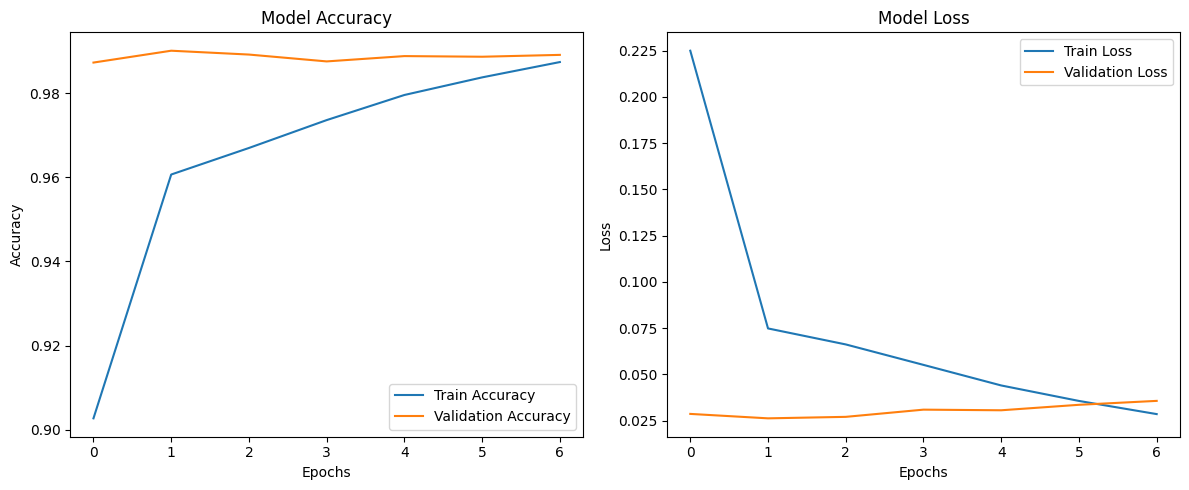

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Bidirectional LSTM
history = Bidirectional_LSTM_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=weights,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7914 - loss: 0.5032 - val_accuracy: 0.9851 - val_loss: 0.0334
Epoch 2/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9577 - loss: 0.0758 - val_accuracy: 0.9870 - val_loss: 0.0292
Epoch 3/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9638 - loss: 0.0687 - val_accuracy: 0.9888 - val_loss: 0.0279
Epoch 4/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9708 - loss: 0.0586 - val_accuracy: 0.9876 - val_loss: 0.0288
Epoch 5/30
2340/2340 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9745 - loss: 0.0507 - val_accuracy: 0.9882 - val_loss: 0.0295


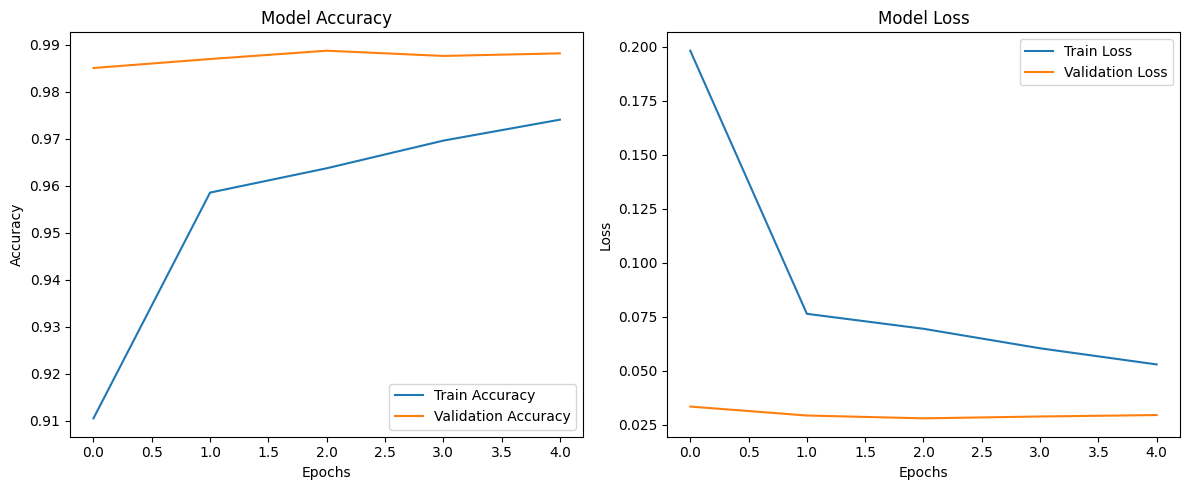

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Bidirectional GRU
bidir_gru_predictions = Bidirectional_GRU_model.predict(X_test)
bidir_gru_predicted_labels = bidir_gru_predictions.argmax(axis=1)
bidirectional_gru_accuracy = accuracy_score(y_test, bidir_gru_predicted_labels)

# Bidirectional LSTM
bidir_lstm_predictions = Bidirectional_LSTM_model.predict(X_test)
bidir_lstm_predicted_labels = bidir_lstm_predictions.argmax(axis=1)
bidirectional_lstm_accuracy = accuracy_score(y_test, bidir_lstm_predicted_labels)


print(f"Bidirectional GRU Test Accuracy: {bidirectional_gru_accuracy:.4f}")
print(f"Bidirectional LSTM Test Accuracy: {bidirectional_lstm_accuracy:.4f}")


875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Bidirectional GRU Test Accuracy: 0.9917
Bidirectional LSTM Test Accuracy: 0.9885


In [ ]:
from sklearn.metrics import classification_report

# Bidirectional GRU
test_predicted_labels_bidir_gru = bidir_gru_predictions.argmax(axis=1)
test_classification_report_bidir_gru = classification_report(y_test, test_predicted_labels_bidir_gru, target_names=label_mapping.values())

# Bidirectional LSTM
test_predicted_labels_bidir_lstm = bidir_lstm_predictions.argmax(axis=1)
test_classification_report_bidir_lstm = classification_report(y_test, test_predicted_labels_bidir_lstm, target_names=label_mapping.values())

print("Classification Report for Bidirectional GRU:")
print(test_classification_report_bidir_gru)

print("Classification Report for Bidirectional LSTM:")
print(test_classification_report_bidir_lstm)


Classification Report for Bidirectional GRU:
              precision    recall  f1-score   support

     sadness       1.00      0.99      1.00      8821
         joy       1.00      0.99      0.99      9714
        love       0.99      1.00      1.00      1839
       anger       0.98      0.99      0.98      3897
        fear       0.98      0.99      0.98      3001
    surprise       0.97      0.97      0.97       697

    accuracy                           0.99     27969
   macro avg       0.99      0.99      0.99     27969
weighted avg       0.99      0.99      0.99     27969

Classification Report for Bidirectional LSTM:
              precision    recall  f1-score   support

     sadness       1.00      0.99      0.99      8821
         joy       1.00      0.98      0.99      9714
        love       0.96      1.00      0.98      1839
       anger       0.97      0.99      0.98      3897
        fear       0.98      0.98      0.98      3001
    surprise       0.94      1.00      0.

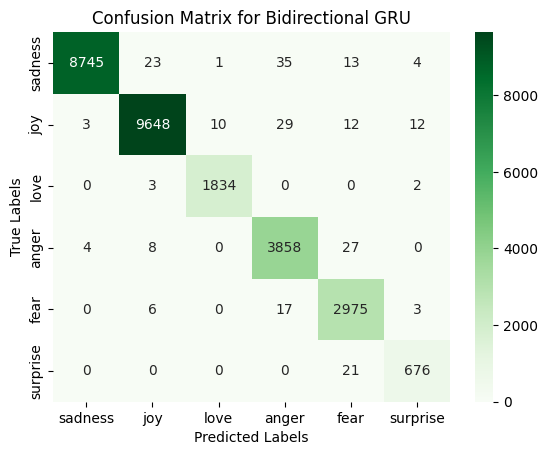

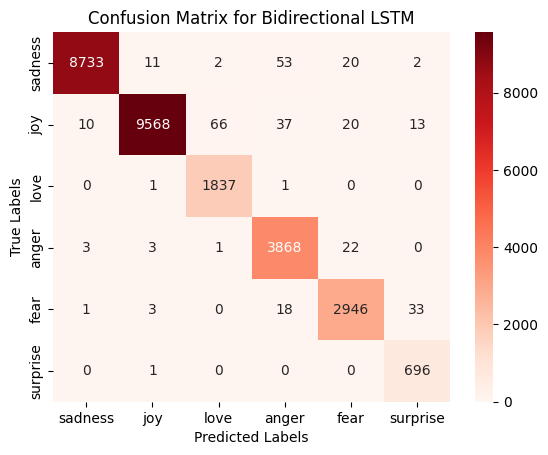

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

heatmap_colors = {
    "Standard RNN": "Blues",
    "Bidirectional RNN": "Blues",
    "Standard GRU": "Greens",
    "Bidirectional GRU": "Greens",
    "Standard LSTM": "Reds",
    "Bidirectional LSTM": "Reds"
}

# Bidirectional GRU
cm_bidir_gru = confusion_matrix(y_test, test_predicted_labels_bidir_gru)
sns.heatmap(cm_bidir_gru, annot=True, fmt='d', cmap=heatmap_colors["Bidirectional GRU"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bidirectional GRU')
plt.show()

# Bidirectional LSTM
cm_bidir_lstm = confusion_matrix(y_test, test_predicted_labels_bidir_lstm)
sns.heatmap(cm_bidir_lstm, annot=True, fmt='d', cmap=heatmap_colors["Bidirectional LSTM"], xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Bidirectional LSTM')
plt.show()


# Ensembling

Ensemble Test Accuracy: 0.9915
Classification Report for Ensemble:
              precision    recall  f1-score   support

     sadness       1.00      0.99      1.00      8821
         joy       1.00      0.99      0.99      9714
        love       0.99      1.00      0.99      1839
       anger       0.98      0.99      0.98      3897
        fear       0.98      0.99      0.98      3001
    surprise       0.96      0.98      0.97       697

    accuracy                           0.99     27969
   macro avg       0.98      0.99      0.99     27969
weighted avg       0.99      0.99      0.99     27969



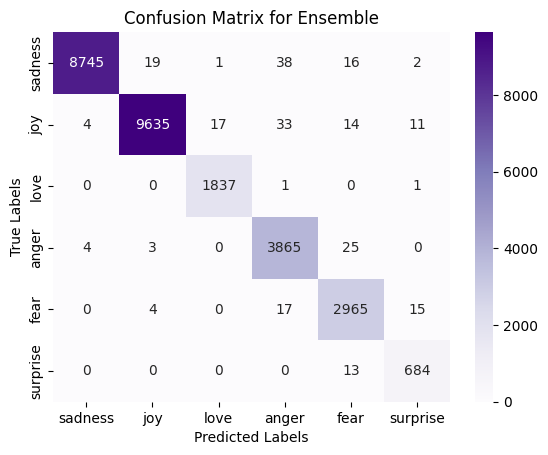

In [ ]:
# Average the probabilities from the Bidirectional GRU and Bidirectional LSTM
ensemble_probs = (bidir_gru_predictions + bidir_lstm_predictions) / 2

# Get the final predicted labels from the ensemble
ensemble_predicted_labels = ensemble_probs.argmax(axis=1)

# Calculate and display ensemble accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_predicted_labels)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

# Classification report for the ensemble
test_classification_report_ensemble = classification_report(
    y_test, ensemble_predicted_labels, target_names=label_mapping.values()
)
print("Classification Report for Ensemble:")
print(test_classification_report_ensemble)

# Confusion matrix for the ensemble
cm_ensemble = confusion_matrix(y_test, ensemble_predicted_labels)
sns.heatmap(
    cm_ensemble, annot=True, fmt='d', cmap='Purples',  # Use "Purples" for purple color
    xticklabels=label_mapping.values(), yticklabels=label_mapping.values()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Ensemble')
plt.show()